# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

In [15]:
conda install -c conda-forge wordcloud=1.6.0 

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Note: you may need to restart the kernel to use updated packages.


In [16]:
!pip install wordcloud

     |████████████████████████████████| 458 kB 24.6 MB/s eta 0:00:01


In [17]:
from wordcloud import WordCloud,STOPWORDS

## Load Data

In [18]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [19]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [20]:
print(df_reviews.shape)

(47331, 17)


In [21]:
#Summary of the dataset
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


## EDA

Let's check the number of movies and reviews over years.

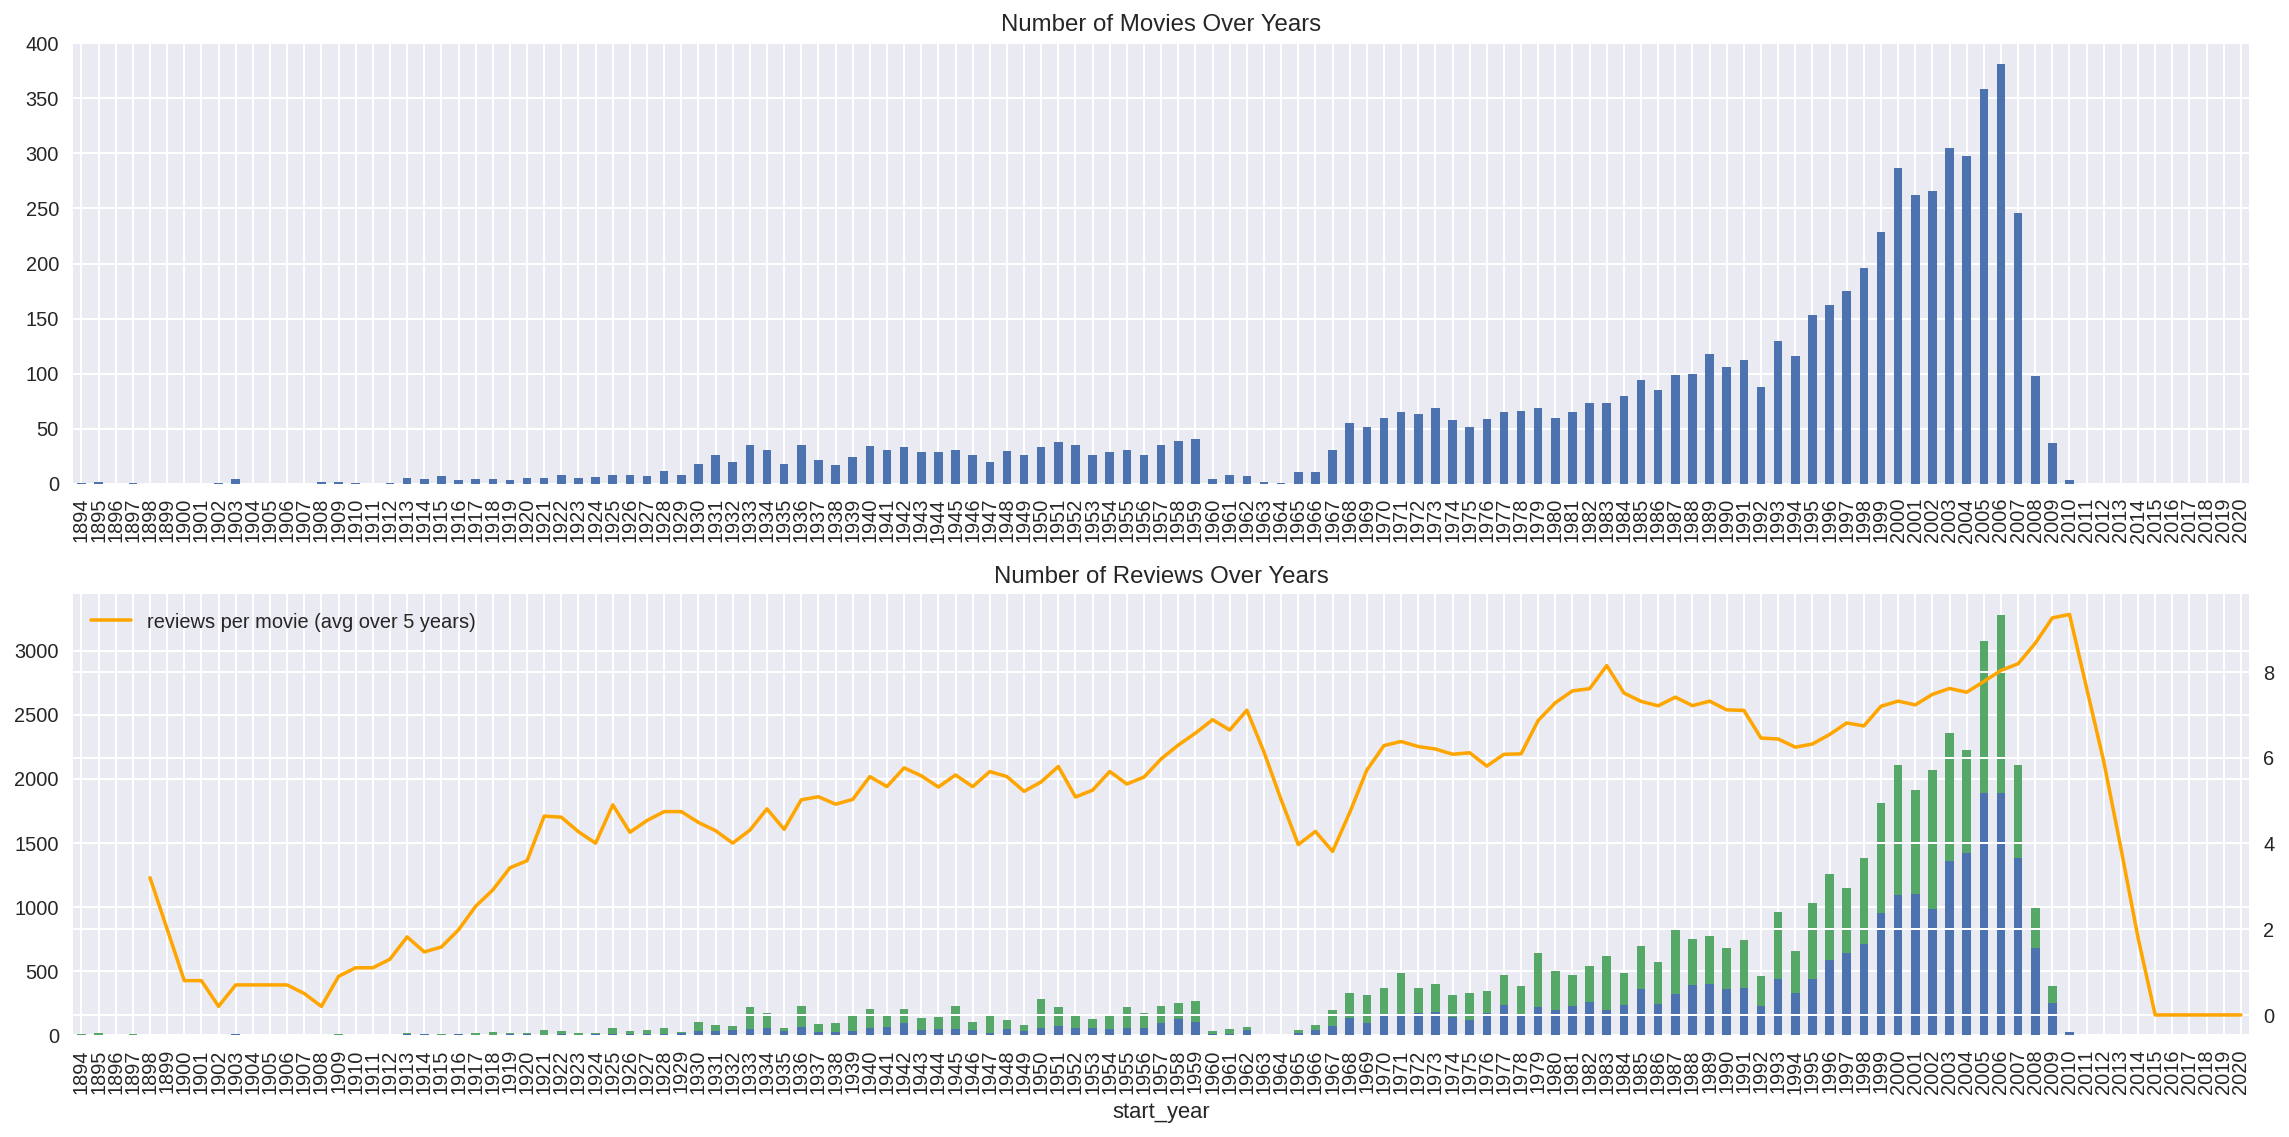

In [22]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

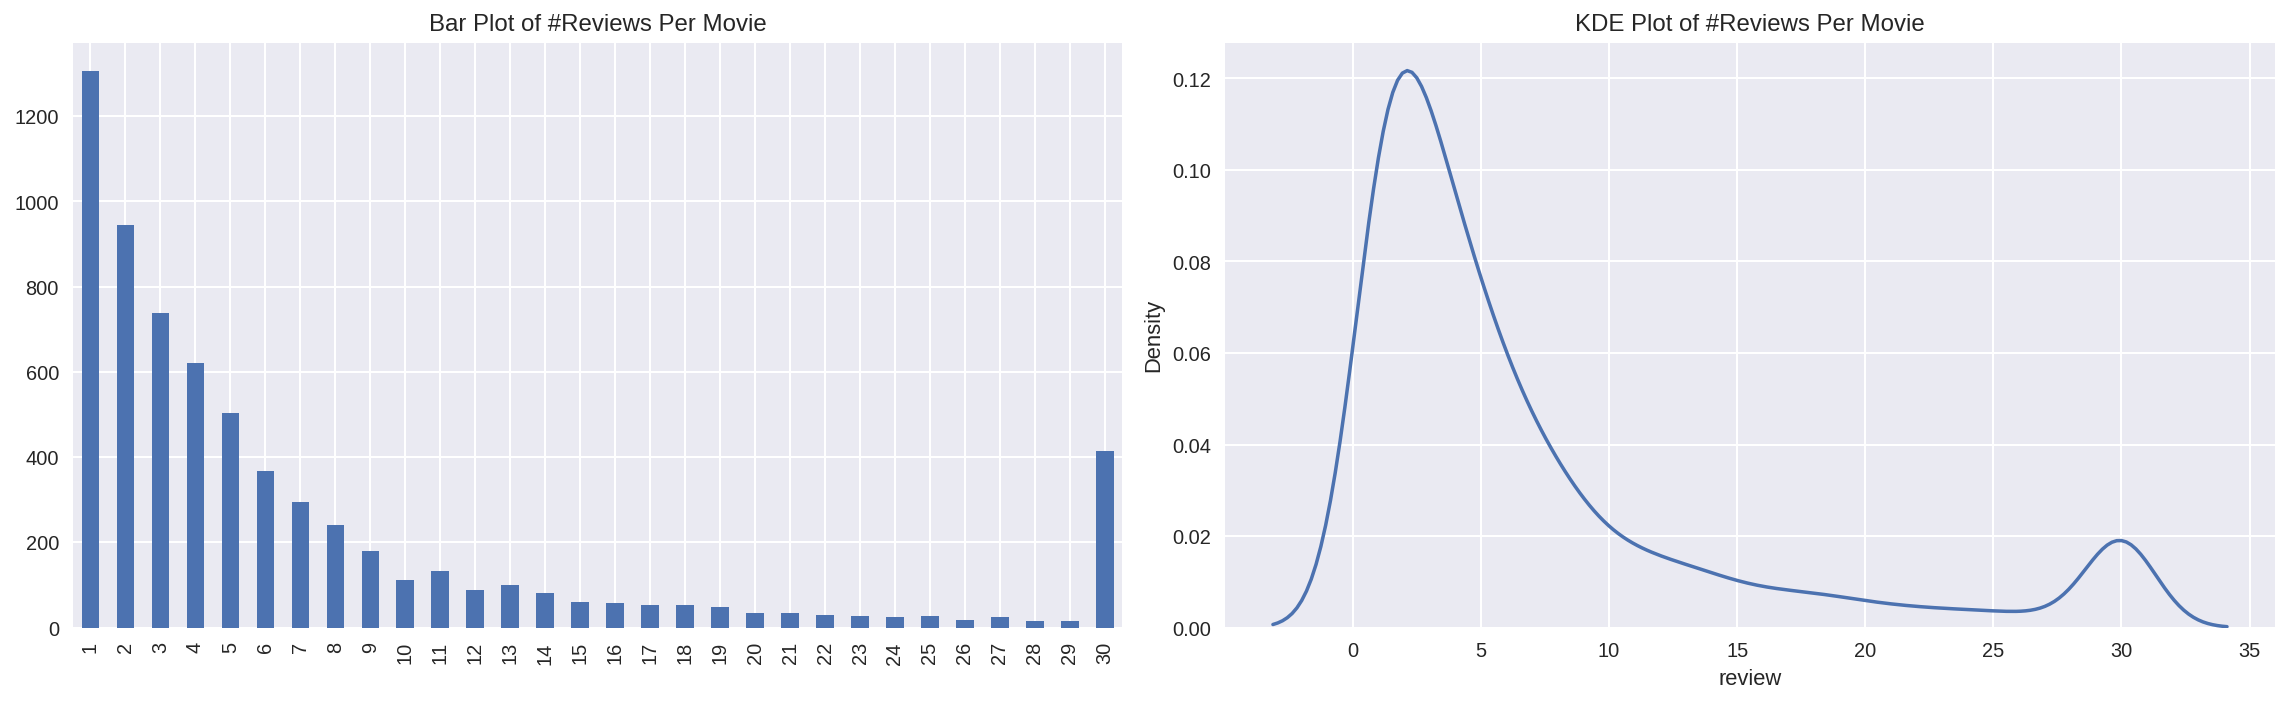

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [24]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

Reviews are balanced in the 'pos' column, which determines whether they are positive or negative

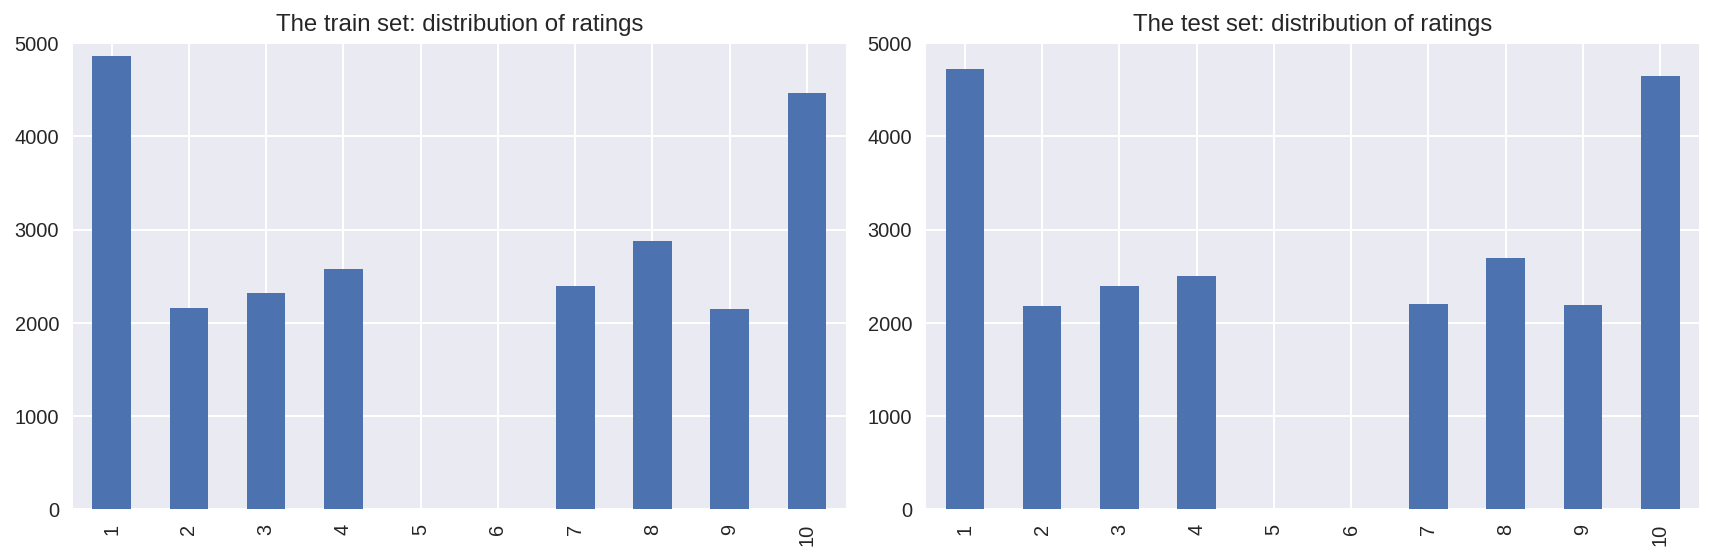

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


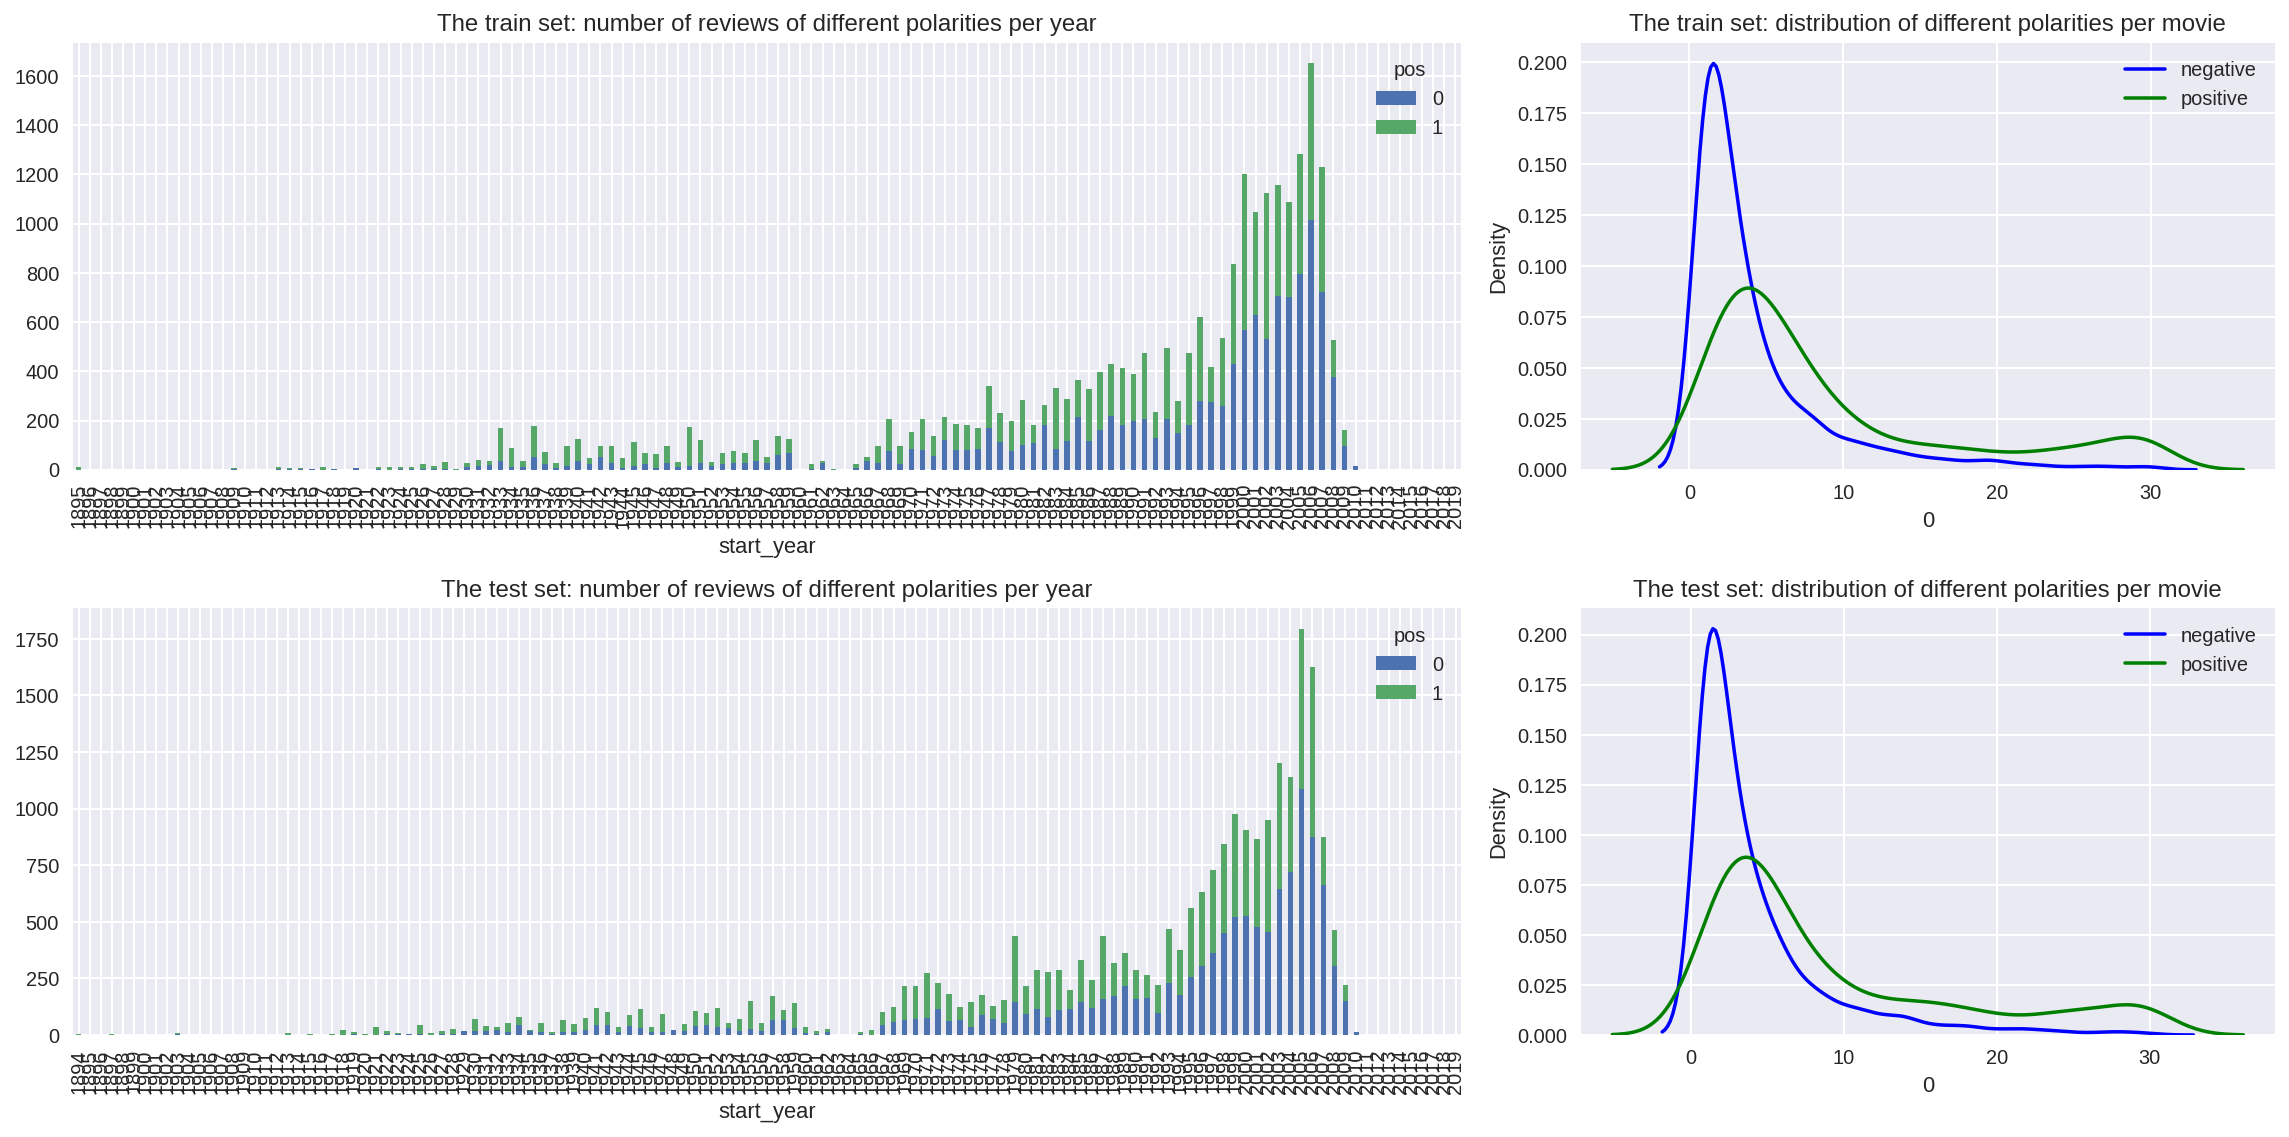

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

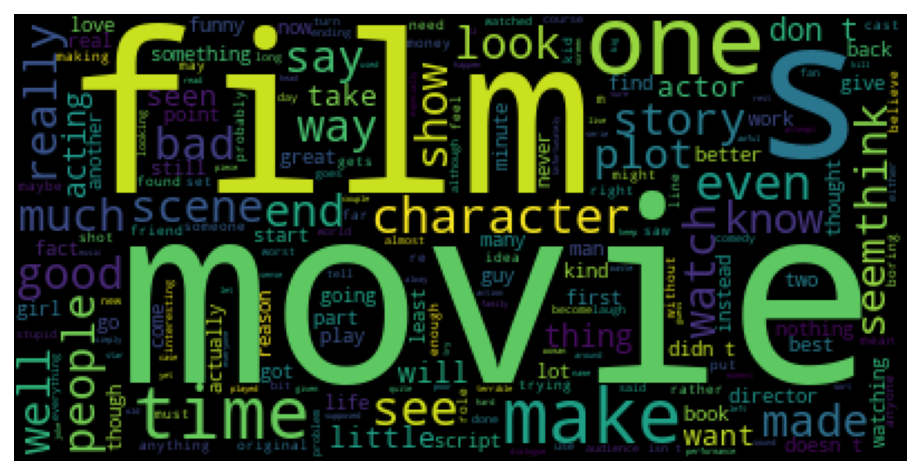

In [27]:
text = list(df_reviews[df_reviews["pos"] == 0].review.values)
wordcloud = WordCloud(stopwords=STOPWORDS).generate(str(text))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

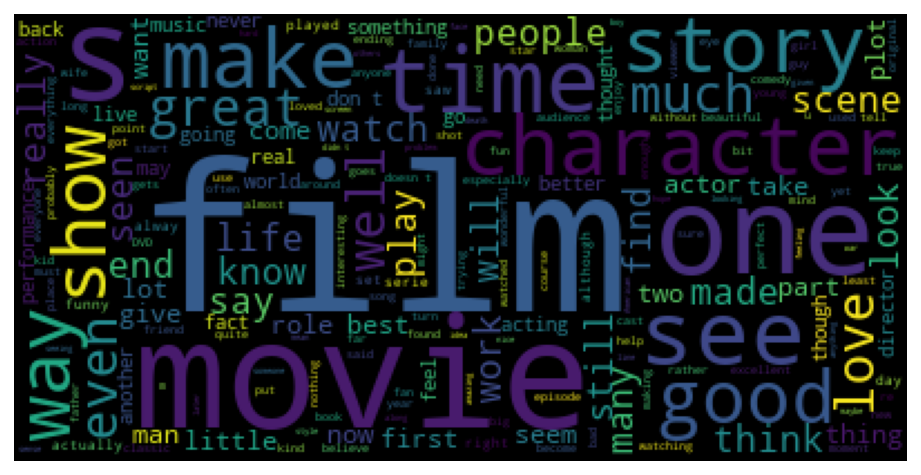

In [28]:
text = list(df_reviews[df_reviews["pos"] == 1].review.values)
wordcloud = WordCloud(stopwords=STOPWORDS).generate(str(text))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

From these word clouds, we are not able to judge any starling differences in both the sentiments by looking at words. We don’t see usage of extreme negative connotation or abusive language used while writing negative reviews.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [29]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [30]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [31]:
# Removing all punctuations from Text
mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }
eng_stopwords = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_contractions(text, mapping):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in eng_stopwords])

def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

def preprocess(text):
    text = clean_contractions(text, mapping)
    text = text.lower()
    text = remove_stopwords(text)
    text = lemmatize_words(text)
    
    return text

In [ ]:
preprocess(text)

In [32]:
df_reviews["reviews_preprocessed"]=df_reviews["review"].apply(lambda text: preprocess(text))
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx,reviews_preprocessed
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335,pakage implies warren beatty goldie hawn pulli...
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336,"hell get made?! presenting caper comedy, misbe..."
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489,real story film seems like fly wall drama-docu...
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280,"um .... serious film troubled teen singapore, ..."
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281,totally agree garryjohal singapore's comment f...


In [19]:
corpus = df_reviews['reviews_preprocessed']

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Working with models

### Model 0 - Constant

In [34]:
from sklearn.dummy import DummyClassifier

In [35]:
clf_dummy = DummyClassifier(random_state=42) 
#establishing random_state for reproducibility
clf_dummy.fit(df_reviews_train, train_target)
y_pred = clf_dummy.predict(df_reviews_train)

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5
None


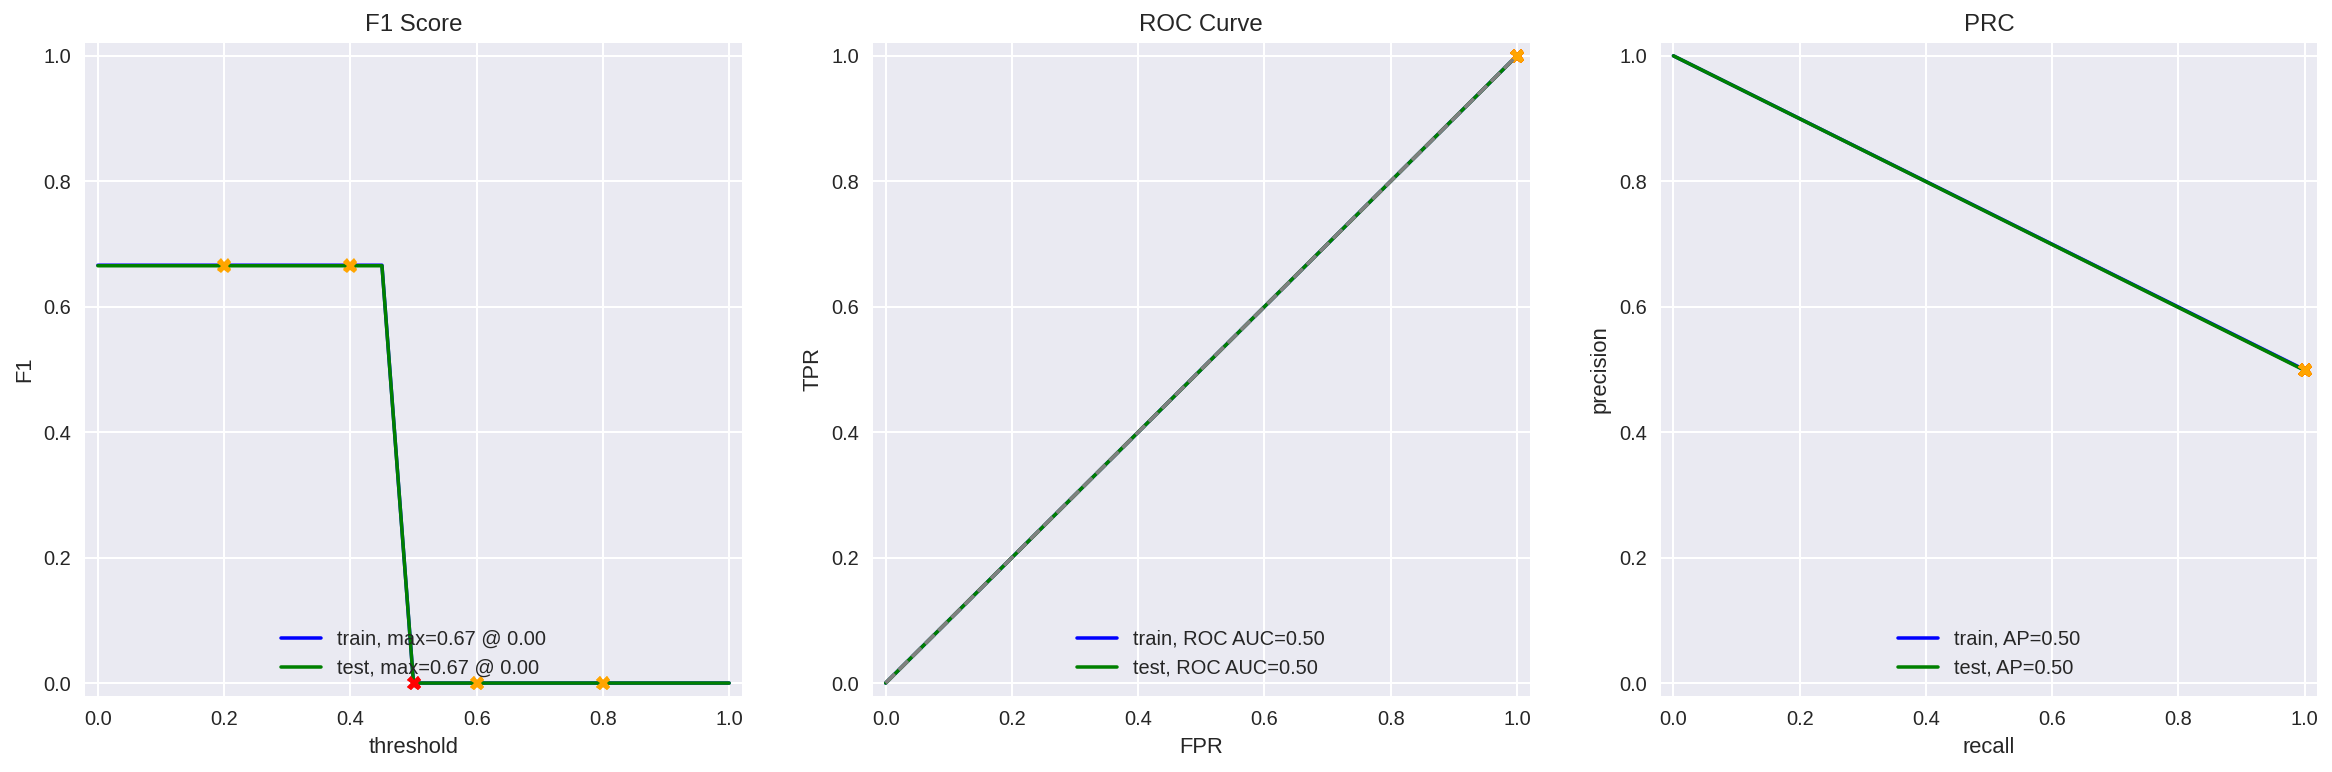

In [23]:
print(evaluate_model(clf_dummy, df_reviews_train, train_target, df_reviews_test, test_target))

### Preprocessing Pipeline and Training Models

In [50]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

preprocessing_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer())
])
  
print("Preprocessing training data...")
train_preprocessed = preprocessing_pipeline.fit_transform(df_reviews_train.reviews_preprocessed)

print("Preprocessing test data...")
test_preprocessed = preprocessing_pipeline.transform(df_reviews_test.reviews_preprocessed)

Preprocessing training data...
Preprocessing test data...


In [51]:
train_preprocessed[0,:].data

array([0.06852801, 0.17862811, 0.09570036, 0.05389827, 0.14031401,
       0.21463403, 0.11366115, 0.08244669, 0.08806844, 0.17732413,
       0.11425959, 0.06984658, 0.08119337, 0.17382847, 0.09067431,
       0.15633739, 0.15411978, 0.14455494, 0.0796149 , 0.0470623 ,
       0.17177842, 0.13620456, 0.09604452, 0.0620724 , 0.22335526,
       0.0883294 , 0.03348969, 0.06580417, 0.03103107, 0.10912543,
       0.06192395, 0.0676609 , 0.03750932, 0.14401037, 0.11425959,
       0.04364015, 0.12304836, 0.13006356, 0.14245481, 0.15686937,
       0.12304836, 0.09384779, 0.07996796, 0.09062931, 0.16990688,
       0.11916062, 0.15834994, 0.06851996, 0.06687204, 0.16818522,
       0.04527641, 0.1015429 , 0.13601833, 0.06509317, 0.04484416,
       0.08010531, 0.13373358, 0.10939263, 0.04719316, 0.09062931,
       0.18150027, 0.29376505, 0.12484625, 0.10491287, 0.10114255,
       0.15455432, 0.07045373, 0.09335746, 0.06945672])

In [52]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

nb_classifier = MultinomialNB()
lr_classifier = LogisticRegression(multi_class="ovr")

print("Training Naive Bayes classifier...")
nb_classifier.fit(train_preprocessed, df_reviews_train.pos)

print("Training Logistic Regression classifier...")
lr_classifier.fit(train_preprocessed, df_reviews_train.pos)

Training Naive Bayes classifier...
Training SVM classifier...
Training Logistic Regression classifier...


LogisticRegression(multi_class='ovr')

### Multinomia NB Classifier

#### Grid Search

In [79]:
# Inspect nb's hyperparameters
nb_classifier.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}

In [80]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

# Define a grid of hyperparameter 'params_nb'
params_nb = {
    'alpha': [0, 1],
    'fit_prior': [True, False]
    }
# Instantiate 'grid_rf'
grid_nb = GridSearchCV(estimator=nb_classifier,                       
                       param_grid=params_nb,                        
                       cv= 10,                       
                       verbose=1,                       
                       n_jobs=-1)

In [82]:
# Fit 'grid_nb' to the training set
grid_nb.fit(train_preprocessed, df_reviews_train.pos)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


GridSearchCV(cv=10, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0, 1], 'fit_prior': [True, False]},
             verbose=1)

In [83]:
# Extract the best hyperparameters from 'grid_nb'
best_hyperparams = grid_nb.best_params_
print('Best hyperparameters:\n', best_hyperparams)

Best hyperparameters:
 {'alpha': 1, 'fit_prior': False}


In [86]:
nb_classifier = MultinomialNB(alpha= 1.0, fit_prior= False)
nb_classifier.fit(train_preprocessed, df_reviews_train.pos)

MultinomialNB(fit_prior=False)

#### Evaluating Model

          train  test
Accuracy   0.91  0.83
F1         0.91  0.82
APS        0.97  0.91
ROC AUC    0.97  0.91


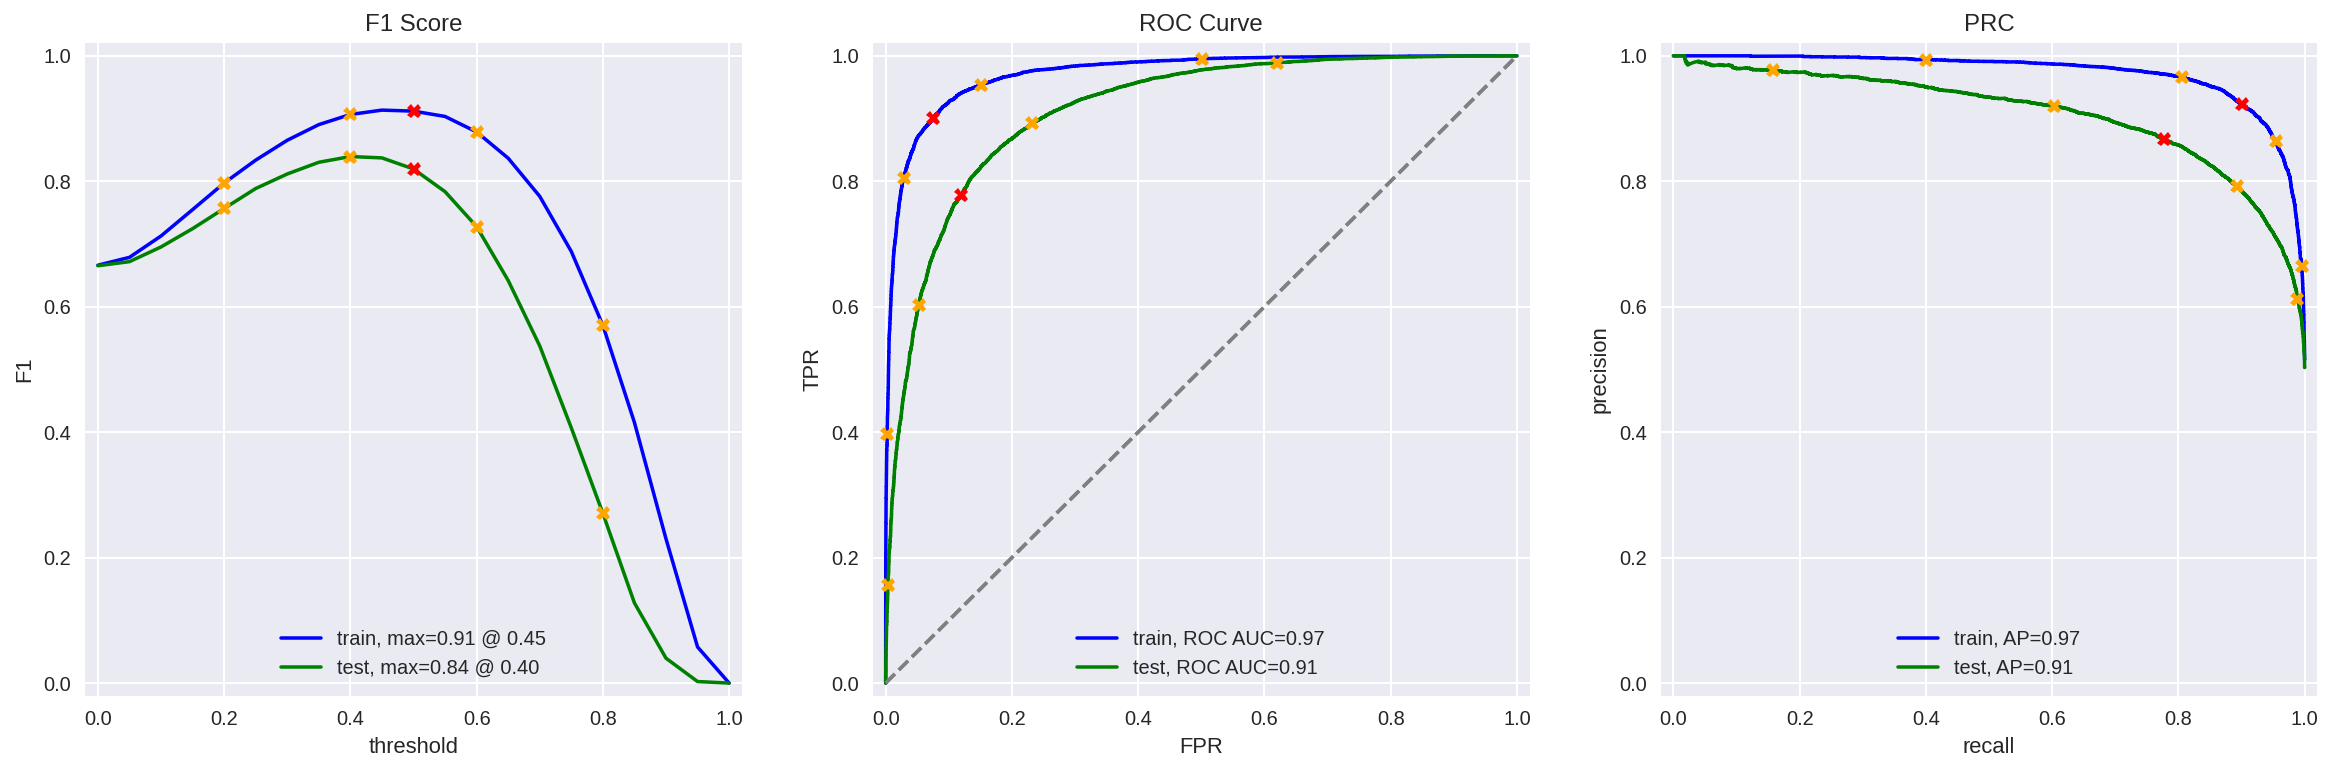

In [87]:
evaluate_model(nb_classifier, train_preprocessed, train_target, test_preprocessed, test_target)

Model performance is not good, with a F1 score of 0.83.

### LogisticRegression Classifier

#### Grid Search

In [28]:
# Define a grid of hyperparameter 'params_lr'
param_grid_lr = {
    'max_iter': [20, 50, 100, 200, 500, 1000],                      
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],   
    'class_weight': ['balanced']                                    
}

In [29]:
# Instantiate 'grid_lr'
logModel_grid = GridSearchCV(estimator=LogisticRegression(random_state=1234), param_grid=param_grid_lr, verbose=1, cv=10, n_jobs=-1)

# Fit 'grid_lr' to the training set
logModel_grid.fit(train_preprocessed, df_reviews_train.pos)

# Extract the best hyperparameters from 'grid_lr'
print(logModel_grid.best_estimator_)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
LogisticRegression(class_weight='balanced', max_iter=50, random_state=1234)


In [30]:
lr_classifier = LogisticRegression(class_weight='balanced', max_iter=50, random_state=1234)
lr_classifier.fit(train_preprocessed, df_reviews_train.pos)

LogisticRegression(class_weight='balanced', max_iter=50, random_state=1234)

#### Evaluating Mode

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


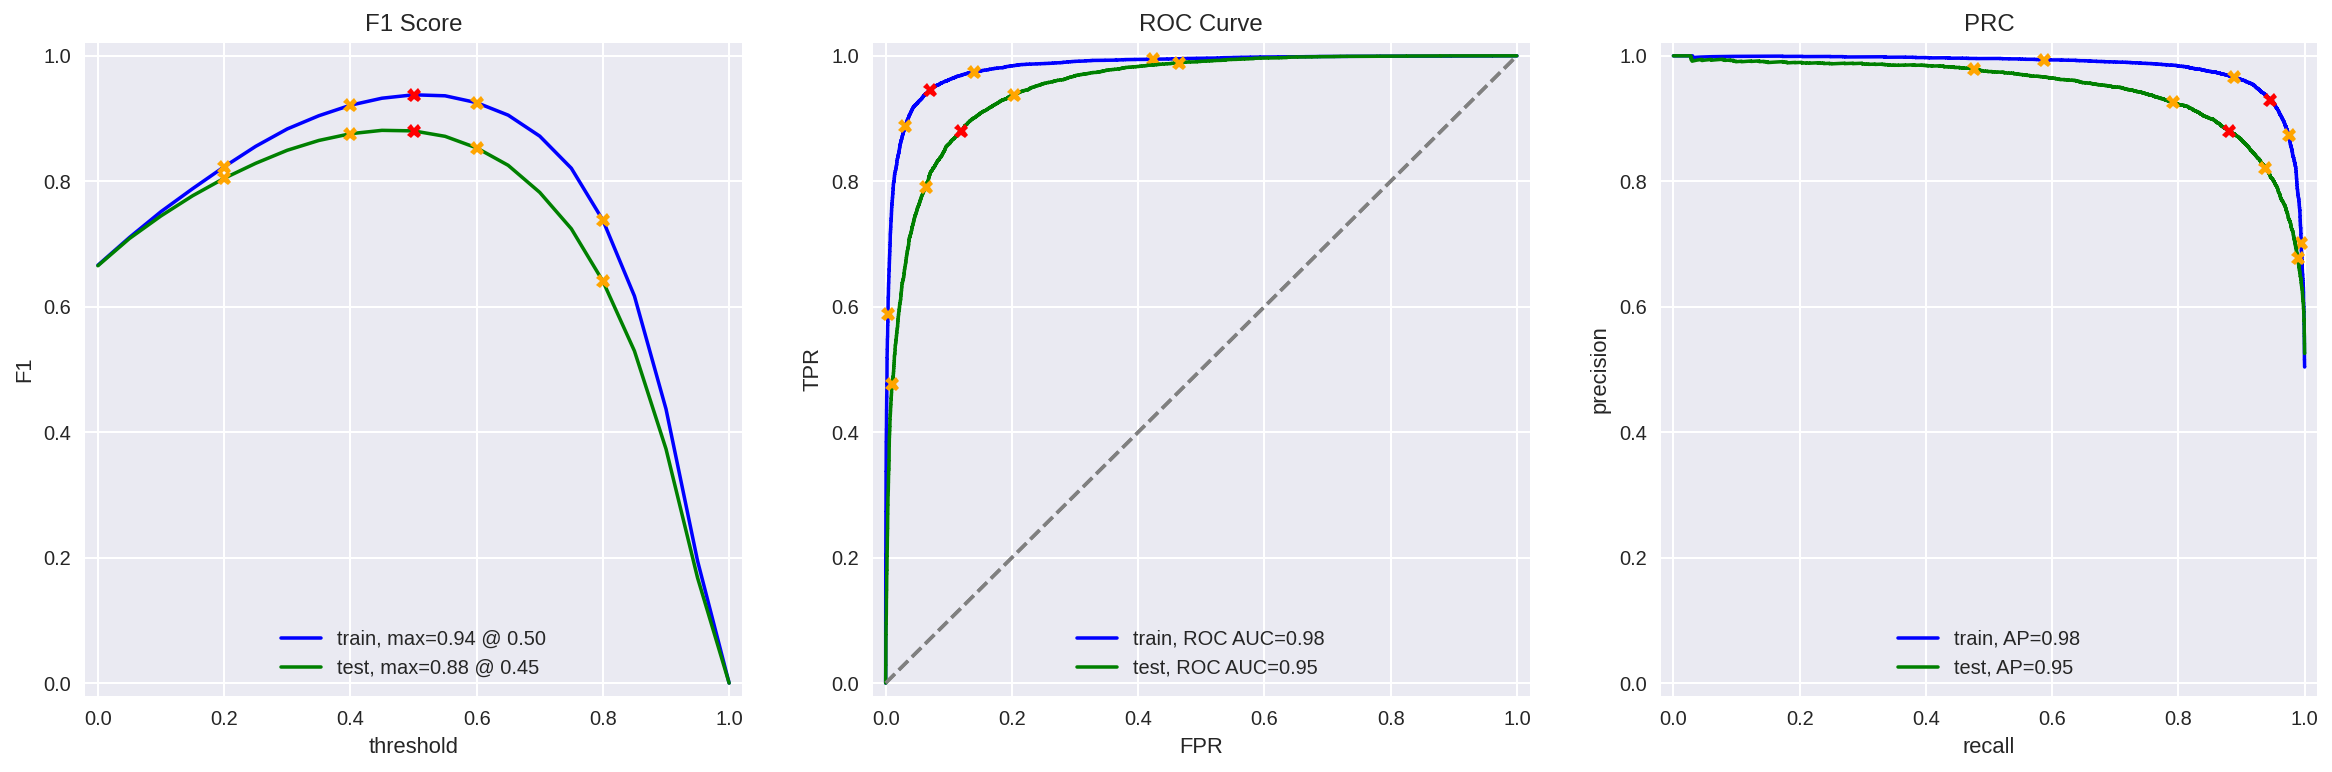

In [31]:
evaluate_model(lr_classifier, train_preprocessed, train_target, test_preprocessed, test_target)

Model performance is good, with a F1 score of 0.88.

## My Reviews

In [36]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews["review"].apply(lambda text: preprocess(text))
my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.","simply like it, kind movie."
1,"Well, I was bored and felt asleep in the middl...","well, bored felt asleep middle movie."
2,I was really fascinated with the movie,really fascinated movie
3,Even the actors looked really old and disinter...,"even actor looked really old disinterested, go..."
4,I didn't expect the reboot to be so good! Writ...,expect reboot good! writer really cared source...
5,"The movie had its upsides and downsides, but I...","movie upside downsides, feel like overall dece..."
6,What a rotten attempt at a comedy. Not a singl...,"rotten attempt comedy. single joke lands, ever..."
7,Launching on Netflix was a brave move & I real...,launching netflix brave move & really apprecia...


In [47]:
print("Preprocessing my reviews...")
my_reviews_preprocessed = preprocessing.transform(my_reviews.review_norm)

Preprocessing my reviews...


In [43]:
my_reviews_preprocessed.shape

(8, 63)

In [44]:
my_reviews_preprocessed[0,:].data

array([0.51044116, 0.28649564, 0.36914727, 0.51044116, 0.51044116])

### Validate MultinomialNB

In [60]:
# Predict on unseen data
pred_test_nb = nb_classifier.predict(my_reviews_preprocessed)
print(pred_test)

[0 0 1 0 0 0 0 1]


In [61]:
my_reviews_prediction = pd.DataFrame( { 'Review': my_reviews["review"] , 'Prediction': pred_test_nb } )
my_reviews_prediction.shape
my_reviews_prediction

,Review,Prediction
0,"I did not simply like it, not my kind of movie.",0
1,"Well, I was bored and felt asleep in the middl...",0
2,I was really fascinated with the movie,1
3,Even the actors looked really old and disinter...,0
4,I didn't expect the reboot to be so good! Writ...,0
5,"The movie had its upsides and downsides, but I...",0
6,What a rotten attempt at a comedy. Not a singl...,0
7,Launching on Netflix was a brave move & I real...,1


### Validate LogisticRegression

In [62]:
# Predict on unseen data
pred_test_lr = lr_classifier.predict(my_reviews_preprocessed)
print(pred_test)

[0 0 1 0 0 0 0 1]


In [63]:
my_reviews_prediction = pd.DataFrame( { 'Review': my_reviews["review"] , 'Prediction': pred_test_lr } )
my_reviews_prediction.shape
my_reviews_prediction

,Review,Prediction
0,"I did not simply like it, not my kind of movie.",0
1,"Well, I was bored and felt asleep in the middl...",0
2,I was really fascinated with the movie,1
3,Even the actors looked really old and disinter...,0
4,I didn't expect the reboot to be so good! Writ...,0
5,"The movie had its upsides and downsides, but I...",0
6,What a rotten attempt at a comedy. Not a singl...,0
7,Launching on Netflix was a brave move & I real...,1


Based on the new reviews, both models performed excellently.

## Conclusions

Both logistic regression and the multinomial naive bayes model performed well, but the logistic regression performed slightly better.